In [1]:
from ARRG import *

In [2]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [3]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [4]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(5000)

# Extract the hadron multiplicity
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
# Extract the transverse mass
sim_mT   = np.sqrt(sim_hadrons[:,:,0]**2 + sim_hadrons[:,:,1]**2 + sim_hadrons[:,:,4]**2)

# Convert into torch objects
sim_mult          = torch.Tensor(sim_mult[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_mT            = torch.Tensor(sim_mT[0:N_events].copy())
exp_mult          = torch.Tensor(exp_mult[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_mult.shape)
print('Simulated multiplicity shape:', sim_mult.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated mT shape:', sim_mT.shape)

# Prepare data for DataLoader
sim_mult          = ObservableDataset(sim_mult)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_mT)
exp_mult          = ObservableDataset(exp_mult)

Experimental observable shape: (1000000, 50, 5)
Simulated observable shape: (1000000, 50, 5)
Simulated z shape: (1000000, 50, 100)
Experimental multiplicity shape: torch.Size([5000])
Simulated multiplicity shape: torch.Size([5000])
Simulated z shape: torch.Size([5000, 50, 100])
Simulated mT shape: torch.Size([5000, 50])


In [ ]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_mult,          batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_mT_dataloader            = DataLoader(sim_mT,            batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_mult,          batch_size = batch_size, shuffle = False)

In [ ]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_mT_dataloader:', len(sim_mT_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 5000
Size of sim_accept_reject_dataloader: 5000
Size of sim_mT_dataloader: 5000
Size of exp_observable_dataloader: 5000


In [ ]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate
learning_rate = 0.01
fixed_binning = True
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6-0.1, 0.80+0.1)#(0.6, 0.80)
b_range  = (0.85-0.1, 1.05+0.1)#(0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 50
Each emission has been zero-padded to a length of 100


In [ ]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([100, 2])


In [ ]:
# Irrelevant parameters for the flow plot that must be initialized for the ARRG class
epochs = 1
learning_rate = 0.01

# Create an ARRG instance
ARRG = ARRG(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
			params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_kinematics_z_dataloader = sim_accept_reject_dataloader, 
			sim_kinematics_mT_dataloader = sim_mT_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
			results_dir = None, params_init = None, fixed_binning = True)

In [ ]:
# Set the optimizer
optimizer = torch.optim.Adam(ARRG.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients!
a_b_gradients, loss_grid = ARRG.ARRG_flow(optimizer, a_b_init)

  0%|                                                                       | 0/100 [00:00<?, ?it/s]

----------------------------------------------
Loss: 31.029306
a: 0.5
Gradient of a: -151.27492
b: 0.75
Gradient of b: -16.163881
----------------------------------------------


  2%|█▏                                                           | 2/100 [02:39<2:11:15, 80.36s/it]

----------------------------------------------
Loss: 32.15144
a: 0.5
Gradient of a: -352.39087
b: 0.79444444
Gradient of b: 72.32837
----------------------------------------------
----------------------------------------------
Loss: 37.645844
a: 0.5
Gradient of a: -554.4364
b: 0.8388889
Gradient of b: 174.43488
----------------------------------------------


  3%|█▊                                                           | 3/100 [04:08<2:16:23, 84.37s/it]

----------------------------------------------
Loss: 47.507317
a: 0.5
Gradient of a: -738.36444
b: 0.8833333
Gradient of b: 267.04453
----------------------------------------------


  4%|██▍                                                          | 4/100 [05:34<2:16:18, 85.20s/it]

----------------------------------------------
Loss: 61.165497
a: 0.5
Gradient of a: -898.6113
b: 0.92777777
Gradient of b: 345.07864
----------------------------------------------


  5%|███                                                          | 5/100 [07:02<2:16:30, 86.22s/it]

----------------------------------------------
Loss: 77.962006
a: 0.5
Gradient of a: -1034.4471
b: 0.9722222
Gradient of b: 408.36017
----------------------------------------------


  7%|████▎                                                        | 7/100 [10:01<2:15:55, 87.69s/it]

----------------------------------------------
Loss: 97.257576
a: 0.5
Gradient of a: -1146.8608
b: 1.0166667
Gradient of b: 457.71826
----------------------------------------------


  8%|████▉                                                        | 8/100 [11:28<2:14:05, 87.45s/it]

----------------------------------------------
Loss: 118.46154
a: 0.5
Gradient of a: -1237.8323
b: 1.0611111
Gradient of b: 494.5046
----------------------------------------------


  9%|█████▍                                                       | 9/100 [12:55<2:12:27, 87.34s/it]

----------------------------------------------
Loss: 141.05339
a: 0.5
Gradient of a: -1310.0813
b: 1.1055555
Gradient of b: 520.49225
----------------------------------------------
----------------------------------------------
Loss: 164.59677
a: 0.5
Gradient of a: -1366.8674
b: 1.15
Gradient of b: 537.653
----------------------------------------------


 10%|██████                                                      | 10/100 [14:22<2:10:46, 87.18s/it]

----------------------------------------------
Loss: 34.19012
a: 0.54444444
Gradient of a: 290.1716
b: 0.75
Gradient of b: -189.15277
----------------------------------------------


 11%|██████▌                                                     | 11/100 [15:48<2:08:56, 86.93s/it]

----------------------------------------------
Loss: 26.762117
a: 0.54444444
Gradient of a: 110.33916
b: 0.79444444
Gradient of b: -133.29648
----------------------------------------------


 12%|███████▏                                                    | 12/100 [17:16<2:07:50, 87.16s/it]

----------------------------------------------
Loss: 23.040651
a: 0.54444444
Gradient of a: -99.00733
b: 0.8388889
Gradient of b: -30.38978
----------------------------------------------


 13%|███████▊                                                    | 13/100 [18:46<2:07:45, 88.11s/it]

----------------------------------------------
Loss: 24.147818
a: 0.54444444
Gradient of a: -306.89465
b: 0.8833333
Gradient of b: 79.38208
----------------------------------------------


 14%|████████▍                                                   | 14/100 [20:18<2:07:42, 89.10s/it]

----------------------------------------------
Loss: 29.950489
a: 0.54444444
Gradient of a: -498.7964
b: 0.92777777
Gradient of b: 179.63647
----------------------------------------------


 15%|█████████                                                   | 15/100 [21:48<2:06:43, 89.46s/it]

----------------------------------------------
Loss: 39.912296
a: 0.54444444
Gradient of a: -669.6831
b: 0.9722222
Gradient of b: 266.25436
----------------------------------------------


 16%|█████████▌                                                  | 16/100 [23:25<2:08:21, 91.69s/it]

----------------------------------------------
Loss: 53.402855
a: 0.54444444
Gradient of a: -818.06915
b: 1.0166667
Gradient of b: 338.40555
----------------------------------------------


 18%|██████████▊                                                 | 18/100 [26:22<2:03:03, 90.04s/it]

----------------------------------------------
Loss: 69.782295
a: 0.54444444
Gradient of a: -944.14685
b: 1.0611111
Gradient of b: 396.36307
----------------------------------------------
----------------------------------------------
Loss: 88.4393
a: 0.54444444
Gradient of a: -1049.2098
b: 1.1055555
Gradient of b: 441.10406
----------------------------------------------


 19%|███████████▍                                                | 19/100 [27:50<2:00:51, 89.52s/it]

----------------------------------------------
Loss: 108.816895
a: 0.54444444
Gradient of a: -1135.4071
b: 1.15
Gradient of b: 474.05344
----------------------------------------------


 20%|████████████                                                | 20/100 [29:17<1:58:14, 88.69s/it]

----------------------------------------------
Loss: 56.35956
a: 0.5888889
Gradient of a: 700.58813
b: 0.75
Gradient of b: -317.92465
----------------------------------------------


 21%|████████████▌                                               | 21/100 [30:45<1:56:31, 88.50s/it]

----------------------------------------------
Loss: 41.789295
a: 0.5888889
Gradient of a: 561.65015
b: 0.79444444
Gradient of b: -321.86093
----------------------------------------------


 22%|█████████████▏                                              | 22/100 [32:13<1:54:52, 88.36s/it]

----------------------------------------------
Loss: 28.988987
a: 0.5888889
Gradient of a: 366.03052
b: 0.8388889
Gradient of b: -244.16534
----------------------------------------------


 23%|█████████████▊                                              | 23/100 [33:41<1:53:09, 88.18s/it]

----------------------------------------------
Loss: 20.592218
a: 0.5888889
Gradient of a: 149.02293
b: 0.8833333
Gradient of b: -131.39185
----------------------------------------------


 24%|██████████████▍                                             | 24/100 [35:10<1:51:54, 88.35s/it]

----------------------------------------------
Loss: 17.340097
a: 0.5888889
Gradient of a: -64.59151
b: 0.92777777
Gradient of b: -15.859144
----------------------------------------------


 26%|███████████████▌                                            | 26/100 [38:05<1:48:15, 87.78s/it]

----------------------------------------------
Loss: 19.04686
a: 0.5888889
Gradient of a: -263.78397
b: 0.9722222
Gradient of b: 90.738525
----------------------------------------------
----------------------------------------------
Loss: 25.215466
a: 0.5888889
Gradient of a: -443.9005
b: 1.0166667
Gradient of b: 184.56471
----------------------------------------------


 27%|████████████████▏                                           | 27/100 [39:33<1:47:05, 88.02s/it]

----------------------------------------------
Loss: 35.24311
a: 0.5888889
Gradient of a: -603.04535
b: 1.0611111
Gradient of b: 264.2887
----------------------------------------------


 28%|████████████████▊                                           | 28/100 [41:01<1:45:32, 87.95s/it]

----------------------------------------------
Loss: 48.496162
a: 0.5888889
Gradient of a: -740.8705
b: 1.1055555
Gradient of b: 329.75507
----------------------------------------------


 29%|█████████████████▍                                          | 29/100 [42:28<1:43:53, 87.80s/it]

----------------------------------------------
Loss: 64.35227
a: 0.5888889
Gradient of a: -858.17847
b: 1.15
Gradient of b: 381.57645
----------------------------------------------


 30%|██████████████████                                          | 30/100 [43:56<1:42:13, 87.62s/it]

----------------------------------------------
Loss: 95.73398
a: 0.6333333
Gradient of a: 1061.8859
b: 0.75
Gradient of b: -393.13327
----------------------------------------------


 31%|██████████████████▌                                         | 31/100 [45:24<1:41:11, 87.99s/it]

----------------------------------------------
Loss: 76.12441
a: 0.6333333
Gradient of a: 975.23224
b: 0.79444444
Gradient of b: -472.70578
----------------------------------------------


 32%|███████████████████▏                                        | 32/100 [46:53<1:40:01, 88.26s/it]

----------------------------------------------
Loss: 55.313824
a: 0.6333333
Gradient of a: 813.3805
b: 0.8388889
Gradient of b: -447.49188
----------------------------------------------


 33%|███████████████████▊                                        | 33/100 [48:21<1:38:13, 87.96s/it]

----------------------------------------------
Loss: 37.397438
a: 0.6333333
Gradient of a: 605.1175
b: 0.8833333
Gradient of b: -351.52078
----------------------------------------------


 34%|████████████████████▍                                       | 34/100 [49:50<1:37:05, 88.27s/it]

----------------------------------------------
Loss: 24.4072
a: 0.6333333
Gradient of a: 382.9141
b: 0.92777777
Gradient of b: -231.65561
----------------------------------------------


 35%|█████████████████████                                       | 35/100 [51:18<1:35:42, 88.34s/it]

----------------------------------------------
Loss: 16.807781
a: 0.6333333
Gradient of a: 165.16971
b: 0.9722222
Gradient of b: -111.21038
----------------------------------------------


 36%|█████████████████████▌                                      | 36/100 [52:47<1:34:35, 88.67s/it]

----------------------------------------------
Loss: 14.395842
a: 0.6333333
Gradient of a: -39.411022
b: 1.0166667
Gradient of b: 0.8811749
----------------------------------------------


 37%|██████████████████████▏                                     | 37/100 [54:15<1:32:49, 88.41s/it]

----------------------------------------------
Loss: 16.705967
a: 0.6333333
Gradient of a: -226.47594
b: 1.0611111
Gradient of b: 100.876564
----------------------------------------------


 38%|██████████████████████▊                                     | 38/100 [55:42<1:30:55, 87.99s/it]

----------------------------------------------
Loss: 23.158443
a: 0.6333333
Gradient of a: -393.90915
b: 1.1055555
Gradient of b: 187.1255
----------------------------------------------


 39%|███████████████████████▍                                    | 39/100 [57:11<1:29:42, 88.23s/it]

----------------------------------------------
Loss: 33.128323
a: 0.6333333
Gradient of a: -541.029
b: 1.15
Gradient of b: 259.15317
----------------------------------------------


 40%|████████████████████████                                    | 40/100 [58:42<1:29:07, 89.13s/it]

----------------------------------------------
Loss: 149.84111
a: 0.67777777
Gradient of a: 1362.0984
b: 0.75
Gradient of b: -412.96555
----------------------------------------------


 41%|███████████████████████▊                                  | 41/100 [1:00:10<1:27:05, 88.57s/it]

----------------------------------------------
Loss: 127.61534
a: 0.67777777
Gradient of a: 1330.9683
b: 0.79444444
Gradient of b: -572.45294
----------------------------------------------


 42%|████████████████████████▎                                 | 42/100 [1:01:39<1:25:46, 88.74s/it]

----------------------------------------------
Loss: 100.64385
a: 0.67777777
Gradient of a: 1217.338
b: 0.8388889
Gradient of b: -620.8031
----------------------------------------------


 43%|████████████████████████▉                                 | 43/100 [1:03:08<1:24:22, 88.81s/it]

----------------------------------------------
Loss: 74.00606
a: 0.67777777
Gradient of a: 1036.0386
b: 0.8833333
Gradient of b: -564.62225
----------------------------------------------


 44%|█████████████████████████▌                                | 44/100 [1:04:38<1:23:18, 89.25s/it]

----------------------------------------------
Loss: 51.22992
a: 0.67777777
Gradient of a: 820.51117
b: 0.92777777
Gradient of b: -455.34088
----------------------------------------------


 45%|██████████████████████████                                | 45/100 [1:06:09<1:22:18, 89.79s/it]

----------------------------------------------
Loss: 33.759075
a: 0.67777777
Gradient of a: 596.1712
b: 0.9722222
Gradient of b: -329.9874
----------------------------------------------


 46%|██████████████████████████▋                               | 46/100 [1:07:40<1:21:03, 90.06s/it]

----------------------------------------------
Loss: 21.884718
a: 0.67777777
Gradient of a: 376.68225
b: 1.0166667
Gradient of b: -205.23393
----------------------------------------------


 47%|███████████████████████████▎                              | 47/100 [1:09:12<1:20:16, 90.87s/it]

----------------------------------------------
Loss: 15.396805
a: 0.67777777
Gradient of a: 169.25925
b: 1.0611111
Gradient of b: -88.42199
----------------------------------------------


 48%|███████████████████████████▊                              | 48/100 [1:10:45<1:19:04, 91.25s/it]

----------------------------------------------
Loss: 13.852396
a: 0.67777777
Gradient of a: -22.030846
b: 1.1055555
Gradient of b: 16.797928
----------------------------------------------


 49%|████████████████████████████▍                             | 49/100 [1:12:16<1:17:28, 91.15s/it]

----------------------------------------------
Loss: 16.690557
a: 0.67777777
Gradient of a: -194.97589
b: 1.15
Gradient of b: 108.59531
----------------------------------------------


 50%|█████████████████████████████                             | 50/100 [1:13:48<1:16:21, 91.62s/it]

----------------------------------------------
Loss: 215.81908
a: 0.7222222
Gradient of a: 1595.745
b: 0.75
Gradient of b: -381.43185
----------------------------------------------


 51%|█████████████████████████████▌                            | 51/100 [1:15:18<1:14:27, 91.18s/it]

----------------------------------------------
Loss: 193.39334
a: 0.7222222
Gradient of a: 1616.837
b: 0.79444444
Gradient of b: -616.3858
----------------------------------------------


 52%|██████████████████████████████▏                           | 52/100 [1:16:51<1:13:21, 91.71s/it]

----------------------------------------------
Loss: 162.57993
a: 0.7222222
Gradient of a: 1557.9855
b: 0.8388889
Gradient of b: -748.6123
----------------------------------------------


 53%|██████████████████████████████▋                           | 53/100 [1:18:22<1:11:39, 91.48s/it]

----------------------------------------------
Loss: 128.77296
a: 0.7222222
Gradient of a: 1418.767
b: 0.8833333
Gradient of b: -753.7037
----------------------------------------------


 54%|███████████████████████████████▎                          | 54/100 [1:19:55<1:10:18, 91.71s/it]

----------------------------------------------
Loss: 96.856895
a: 0.7222222
Gradient of a: 1225.5214
b: 0.92777777
Gradient of b: -672.8319
----------------------------------------------


 55%|███████████████████████████████▉                          | 55/100 [1:21:24<1:08:16, 91.04s/it]

----------------------------------------------
Loss: 69.51286
a: 0.7222222
Gradient of a: 1007.80396
b: 0.9722222
Gradient of b: -554.1827
----------------------------------------------


 56%|████████████████████████████████▍                         | 56/100 [1:22:56<1:06:58, 91.33s/it]

----------------------------------------------
Loss: 47.75408
a: 0.7222222
Gradient of a: 784.40356
b: 1.0166667
Gradient of b: -424.4168
----------------------------------------------


 57%|█████████████████████████████████                         | 57/100 [1:24:39<1:08:00, 94.88s/it]

----------------------------------------------
Loss: 31.76371
a: 0.7222222
Gradient of a: 565.84564
b: 1.0611111
Gradient of b: -296.02106
----------------------------------------------


 58%|█████████████████████████████████                        | 58/100 [1:26:32<1:10:09, 100.22s/it]

----------------------------------------------
Loss: 21.325956
a: 0.7222222
Gradient of a: 358.32333
b: 1.1055555
Gradient of b: -175.31546
----------------------------------------------


 59%|█████████████████████████████████▋                       | 59/100 [1:28:24<1:10:57, 103.84s/it]

----------------------------------------------
Loss: 16.013247
a: 0.7222222
Gradient of a: 165.62749
b: 1.15
Gradient of b: -65.82115
----------------------------------------------


 61%|██████████████████████████████████▊                      | 61/100 [1:32:09<1:10:20, 108.21s/it]

----------------------------------------------
Loss: 290.71936
a: 0.76666665
Gradient of a: 1764.3994
b: 0.75
Gradient of b: -307.92953
----------------------------------------------
----------------------------------------------
Loss: 270.2385
a: 0.76666665
Gradient of a: 1828.9838
b: 0.79444444
Gradient of b: -607.0606
----------------------------------------------


 62%|███████████████████████████████████▎                     | 62/100 [1:33:59<1:08:53, 108.79s/it]

----------------------------------------------
Loss: 238.01784
a: 0.76666665
Gradient of a: 1823.7861
b: 0.8388889
Gradient of b: -822.6991
----------------------------------------------


 63%|███████████████████████████████████▉                     | 63/100 [1:35:52<1:07:47, 109.94s/it]

----------------------------------------------
Loss: 199.1405
a: 0.76666665
Gradient of a: 1735.7252
b: 0.8833333
Gradient of b: -903.95056
----------------------------------------------


 64%|████████████████████████████████████▍                    | 64/100 [1:37:41<1:05:49, 109.70s/it]

----------------------------------------------
Loss: 159.39185
a: 0.76666665
Gradient of a: 1578.5266
b: 0.92777777
Gradient of b: -869.80383
----------------------------------------------


 65%|█████████████████████████████████████                    | 65/100 [1:39:32<1:04:21, 110.32s/it]

----------------------------------------------
Loss: 122.76404
a: 0.76666665
Gradient of a: 1380.5885
b: 0.9722222
Gradient of b: -771.5348
----------------------------------------------


 67%|██████████████████████████████████████▏                  | 67/100 [1:43:22<1:01:54, 112.57s/it]

----------------------------------------------
Loss: 91.203125
a: 0.76666665
Gradient of a: 1164.7998
b: 1.0166667
Gradient of b: -646.1986
----------------------------------------------
----------------------------------------------
Loss: 65.437355
a: 0.76666665
Gradient of a: 945.1605
b: 1.0611111
Gradient of b: -512.95056
----------------------------------------------


 68%|████████████████████████████████████████                   | 68/100 [1:45:11<59:33, 111.67s/it]

----------------------------------------------
Loss: 45.57619
a: 0.76666665
Gradient of a: 730.13324
b: 1.1055555
Gradient of b: -381.6822
----------------------------------------------


 69%|████████████████████████████████████████▋                  | 69/100 [1:47:02<57:38, 111.56s/it]

----------------------------------------------
Loss: 31.396648
a: 0.76666665
Gradient of a: 525.1478
b: 1.15
Gradient of b: -257.98672
----------------------------------------------


 70%|█████████████████████████████████████████▎                 | 70/100 [1:48:52<55:25, 110.86s/it]

----------------------------------------------
Loss: 371.7998
a: 0.8111111
Gradient of a: 1875.4779
b: 0.75
Gradient of b: -206.14778
----------------------------------------------


 71%|█████████████████████████████████████████▉                 | 71/100 [1:50:43<53:42, 111.11s/it]

----------------------------------------------
Loss: 354.92633
a: 0.8111111
Gradient of a: 1970.8558
b: 0.79444444
Gradient of b: -552.42993
----------------------------------------------


 72%|██████████████████████████████████████████▍                | 72/100 [1:52:36<52:07, 111.68s/it]

----------------------------------------------
Loss: 323.5446
a: 0.8111111
Gradient of a: 2012.2368
b: 0.8388889
Gradient of b: -842.7403
----------------------------------------------


 73%|███████████████████████████████████████████                | 73/100 [1:54:29<50:21, 111.89s/it]

----------------------------------------------
Loss: 281.93768
a: 0.8111111
Gradient of a: 1977.193
b: 0.8833333
Gradient of b: -1005.55365
----------------------------------------------


 74%|███████████████████████████████████████████▋               | 74/100 [1:56:20<48:27, 111.84s/it]

----------------------------------------------
Loss: 236.18912
a: 0.8111111
Gradient of a: 1865.5667
b: 0.92777777
Gradient of b: -1033.5073
----------------------------------------------


 75%|████████████████████████████████████████████▎              | 75/100 [1:58:14<46:47, 112.29s/it]

----------------------------------------------
Loss: 191.4227
a: 0.8111111
Gradient of a: 1698.9943
b: 0.9722222
Gradient of b: -970.01996
----------------------------------------------


 76%|████████████████████████████████████████████▊              | 76/100 [2:00:06<44:51, 112.13s/it]

----------------------------------------------
Loss: 150.64703
a: 0.8111111
Gradient of a: 1501.8278
b: 1.0166667
Gradient of b: -859.8414
----------------------------------------------


 77%|█████████████████████████████████████████████▍             | 77/100 [2:02:00<43:17, 112.93s/it]

----------------------------------------------
Loss: 115.28265
a: 0.8111111
Gradient of a: 1291.1539
b: 1.0611111
Gradient of b: -729.68274
----------------------------------------------


 78%|██████████████████████████████████████████████             | 78/100 [2:03:52<41:17, 112.60s/it]

----------------------------------------------
Loss: 85.866974
a: 0.8111111
Gradient of a: 1077.7211
b: 1.1055555
Gradient of b: -593.8957
----------------------------------------------


 80%|███████████████████████████████████████████████▏           | 80/100 [2:07:33<37:14, 111.73s/it]

----------------------------------------------
Loss: 62.453346
a: 0.8111111
Gradient of a: 868.5566
b: 1.15
Gradient of b: -460.62827
----------------------------------------------
----------------------------------------------
Loss: 456.73926
a: 0.85555553
Gradient of a: 1940.0276
b: 0.75
Gradient of b: -91.63339
----------------------------------------------


 81%|███████████████████████████████████████████████▊           | 81/100 [2:09:25<35:24, 111.81s/it]

----------------------------------------------
Loss: 444.5166
a: 0.85555553
Gradient of a: 2051.4446
b: 0.79444444
Gradient of b: -464.34012
----------------------------------------------


 82%|████████████████████████████████████████████████▍          | 82/100 [2:11:16<33:27, 111.55s/it]

----------------------------------------------
Loss: 415.8106
a: 0.85555553
Gradient of a: 2128.3906
b: 0.8388889
Gradient of b: -814.7855
----------------------------------------------


 83%|████████████████████████████████████████████████▉          | 83/100 [2:13:10<31:45, 112.08s/it]

----------------------------------------------
Loss: 373.7481
a: 0.85555553
Gradient of a: 2141.736
b: 0.8833333
Gradient of b: -1055.2417
----------------------------------------------


 84%|█████████████████████████████████████████████████▌         | 84/100 [2:15:02<29:55, 112.23s/it]

----------------------------------------------
Loss: 324.1342
a: 0.85555553
Gradient of a: 2079.6152
b: 0.92777777
Gradient of b: -1154.624
----------------------------------------------


 85%|██████████████████████████████████████████████████▏        | 85/100 [2:16:52<27:54, 111.65s/it]

----------------------------------------------
Loss: 272.82587
a: 0.85555553
Gradient of a: 1952.8984
b: 0.9722222
Gradient of b: -1139.1322
----------------------------------------------


 86%|██████████████████████████████████████████████████▋        | 86/100 [2:18:42<25:52, 110.92s/it]

----------------------------------------------
Loss: 223.88173
a: 0.85555553
Gradient of a: 1783.8574
b: 1.0166667
Gradient of b: -1055.3068
----------------------------------------------


 87%|███████████████████████████████████████████████████▎       | 87/100 [2:20:32<24:01, 110.88s/it]

----------------------------------------------
Loss: 179.5258
a: 0.85555553
Gradient of a: 1591.3455
b: 1.0611111
Gradient of b: -936.90356
----------------------------------------------


 88%|███████████████████████████████████████████████████▉       | 88/100 [2:22:22<22:07, 110.61s/it]

----------------------------------------------
Loss: 140.82146
a: 0.85555553
Gradient of a: 1388.1556
b: 1.1055555
Gradient of b: -803.3848
----------------------------------------------


 90%|█████████████████████████████████████████████████████      | 90/100 [2:26:05<18:29, 110.97s/it]

----------------------------------------------
Loss: 108.16902
a: 0.85555553
Gradient of a: 1182.8799
b: 1.15
Gradient of b: -665.997
----------------------------------------------


 91%|█████████████████████████████████████████████████████▋     | 91/100 [2:27:57<16:41, 111.29s/it]

----------------------------------------------
Loss: 543.7324
a: 0.9
Gradient of a: 1969.7917
b: 0.75
Gradient of b: 21.142094
----------------------------------------------
----------------------------------------------
Loss: 536.5517
a: 0.9
Gradient of a: 2083.0618
b: 0.79444444
Gradient of b: -356.75632
----------------------------------------------


 92%|██████████████████████████████████████████████████████▎    | 92/100 [2:29:48<14:49, 111.13s/it]

----------------------------------------------
Loss: 511.81274
a: 0.9
Gradient of a: 2182.3335
b: 0.8388889
Gradient of b: -749.0948
----------------------------------------------


 93%|██████████████████████████████████████████████████████▊    | 93/100 [2:31:39<12:57, 111.08s/it]

----------------------------------------------
Loss: 471.25613
a: 0.9
Gradient of a: 2235.0068
b: 0.8833333
Gradient of b: -1056.1198
----------------------------------------------


 94%|███████████████████████████████████████████████████████▍   | 94/100 [2:33:32<11:10, 111.82s/it]

----------------------------------------------
Loss: 419.95645
a: 0.9
Gradient of a: 2220.5195
b: 0.92777777
Gradient of b: -1228.6124
----------------------------------------------


 95%|████████████████████████████████████████████████████████   | 95/100 [2:35:28<09:25, 113.07s/it]

----------------------------------------------
Loss: 363.99316
a: 0.9
Gradient of a: 2138.1328
b: 0.9722222
Gradient of b: -1271.0322
----------------------------------------------


 96%|████████████████████████████████████████████████████████▋  | 96/100 [2:37:25<07:36, 114.10s/it]

----------------------------------------------
Loss: 308.29587
a: 0.9
Gradient of a: 2004.2142
b: 1.0166667
Gradient of b: -1224.0898
----------------------------------------------


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [2:41:25<03:55, 117.90s/it]

----------------------------------------------
Loss: 255.93181
a: 0.9
Gradient of a: 1837.5016
b: 1.0611111
Gradient of b: -1126.2415
----------------------------------------------
----------------------------------------------
Loss: 208.56876
a: 0.9
Gradient of a: 1652.2059
b: 1.1055555
Gradient of b: -1002.1619
----------------------------------------------


100%|███████████████████████████████████████████████████████████| 100/100 [2:45:25<00:00, 99.25s/it]

----------------------------------------------
Loss: 167.01904
a: 0.9
Gradient of a: 1458.2291
b: 1.15
Gradient of b: -866.5427
----------------------------------------------


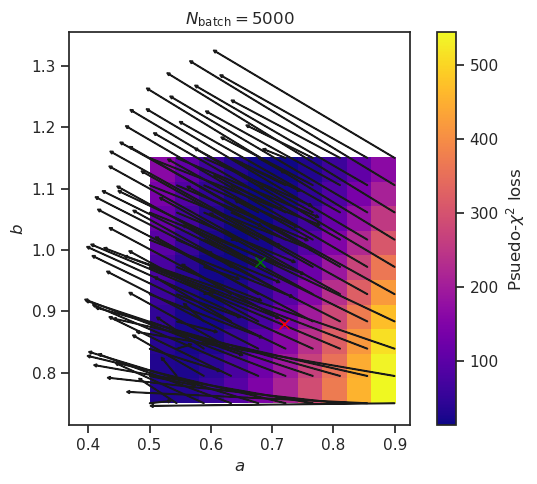

In [ ]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow(loss_grid.reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'Psuedo-$\chi^2$ loss')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/5e4, -gradient[1]/5e4, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_psuedo_chi2_loss_fixed_Nbatch_5e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_psuedo_chi2_loss_fixed_Nbatch_5e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Save the (a,b) values, their gradients, and the loss grid
np.save('flow_data/flow_data_a_b_Nbatch_5e3_fixed.npy', a_b)
np.save('flow_data/flow_data_a_b_gradients_Nbatch_5e3_fixed.npy', a_b_gradients)
np.save('flow_data/flow_data_losses_Nbatch_5e3_fixed.npy', loss_grid)

In [ ]:
for point, gradient in zip(a_b, a_b_gradients):
    print(f'(a, b):\n {point} \nGradient:\n {-gradient}\n')

(a, b):
 [0.5  0.75] 
Gradient:
 [151.27492   16.163881]

(a, b):
 [0.5        0.79444444] 
Gradient:
 [352.39087 -72.32837]

(a, b):
 [0.5       0.8388889] 
Gradient:
 [ 554.4364  -174.43488]

(a, b):
 [0.5       0.8833333] 
Gradient:
 [ 738.36444 -267.04453]

(a, b):
 [0.5        0.92777777] 
Gradient:
 [ 898.6113  -345.07864]

(a, b):
 [0.5       0.9722222] 
Gradient:
 [1034.4471  -408.36017]

(a, b):
 [0.5       1.0166667] 
Gradient:
 [1146.8608  -457.71826]

(a, b):
 [0.5       1.0611111] 
Gradient:
 [1237.8323 -494.5046]

(a, b):
 [0.5       1.1055555] 
Gradient:
 [1310.0813  -520.49225]

(a, b):
 [0.5  1.15] 
Gradient:
 [1366.8674 -537.653 ]

(a, b):
 [0.54444444 0.75      ] 
Gradient:
 [-290.1716   189.15277]

(a, b):
 [0.54444444 0.79444444] 
Gradient:
 [-110.33916  133.29648]

(a, b):
 [0.54444444 0.8388889 ] 
Gradient:
 [99.00733 30.38978]

(a, b):
 [0.54444444 0.8833333 ] 
Gradient:
 [306.89465 -79.38208]

(a, b):
 [0.54444444 0.92777777] 
Gradient:
 [ 498.7964  -179.63647]

In [ ]:
# Loading previous flow map
a_b = np.load('flow_data/flow_data_a_b_Nbatch_5e3.npy')
a_b_gradients = np.load('flow_data/flow_data_a_b_gradients_Nbatch_5e3.npy')
loss_grid = np.load('flow_data/flow_data_losses_Nbatch_5e3.npy')

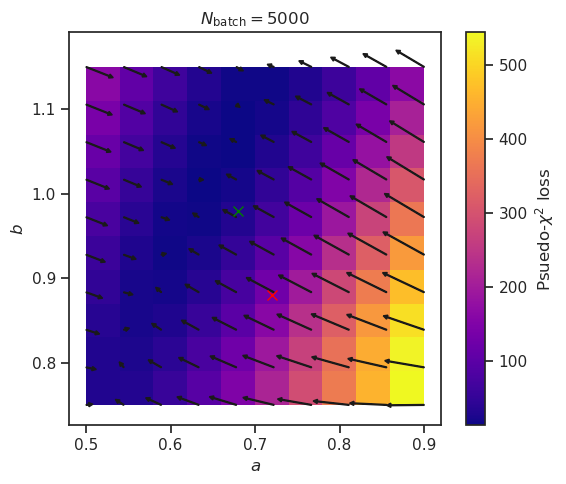

In [ ]:
import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow(loss_grid.reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'Psuedo-$\chi^2$ loss')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/5e4, -gradient[1]/5e4, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('flow_figs/ARRG_flow_psuedo_chi2_loss_fixed_Nbatch_5e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('flow_figs/ARRG_flow_psuedo_chi2_loss_fixed_Nbatch_5e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)